## Forecasting U.S. natural gas prices

## 2. Data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load your dataset
gas = pd.read_csv("data/MHHNGSP.csv")
gas['observation_date'] = pd.to_datetime(gas['observation_date'])
gas.set_index('observation_date', inplace=True)
gas = gas.asfreq('MS')  # monthly data
gas.rename(columns={'MHHNGSP': 'price'}, inplace=True)

Treat this series as monthly data, with observations corresponding to the start of each month

In [3]:
print(gas.head())
print(gas.tail())
print(f"Observations: {gas.notna().sum()}")

                  price
observation_date       
1997-01-01         3.45
1997-02-01         2.15
1997-03-01         1.89
1997-04-01         2.03
1997-05-01         2.25
                  price
observation_date       
2025-06-01         3.02
2025-07-01         3.20
2025-08-01         2.91
2025-09-01         2.97
2025-10-01         3.19
Observations: price    346
dtype: int64


In [4]:
len(gas)

346

In [5]:
# Check gaps
expected = pd.date_range(gas.index.min(), gas.index.max(), freq="MS")
missing = expected.difference(gas.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


### Plot price 

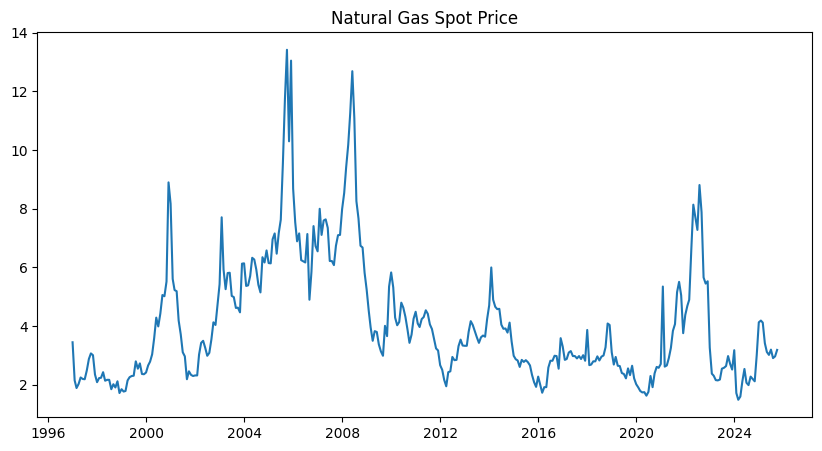

In [6]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['price'], label='Price')
plt.title("Natural Gas Spot Price")
plt.show()

### Logarithmic transformation of gas price

- Variable: Henry Hub natural gas spot price (USD/MMBtu), monthly, NSA
- Transforms: log(p_t) (variance stabilization)

In [7]:
gas['log_price'] = np.log(gas['price'])

### Plot log-level

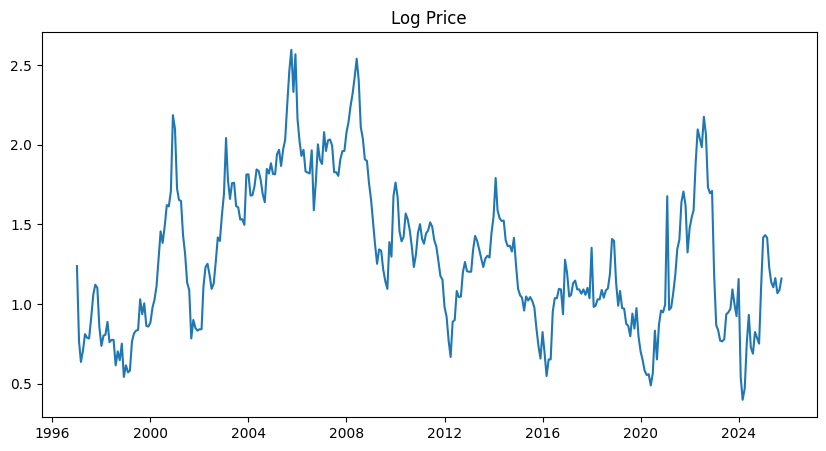

In [8]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['log_price'], label='Log Price')
plt.title("Log Price")
plt.show()

### ACF and PACF of Levels and Differences

(Detect trend, seasonality, cycles quantitatively)

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

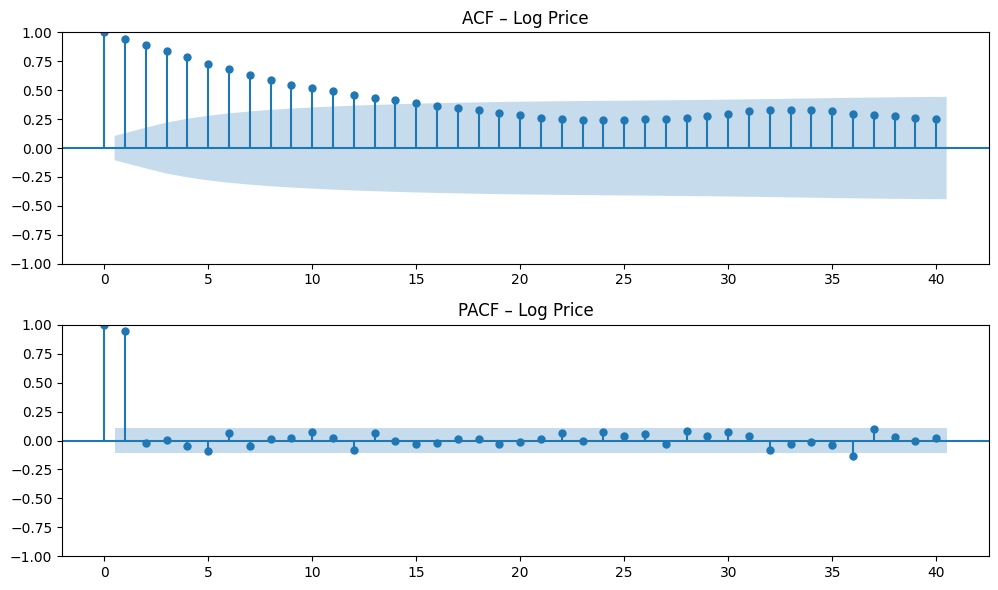

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['log_price'].dropna(), lags=40, ax=ax[0])
# ACF to see seasonal spikes at lag 12, 24
ax[0].set_title("ACF – Log Price")
plot_pacf(gas['log_price'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Log Price")
plt.tight_layout()
plt.show()


### ACF/PACF of differenced log price

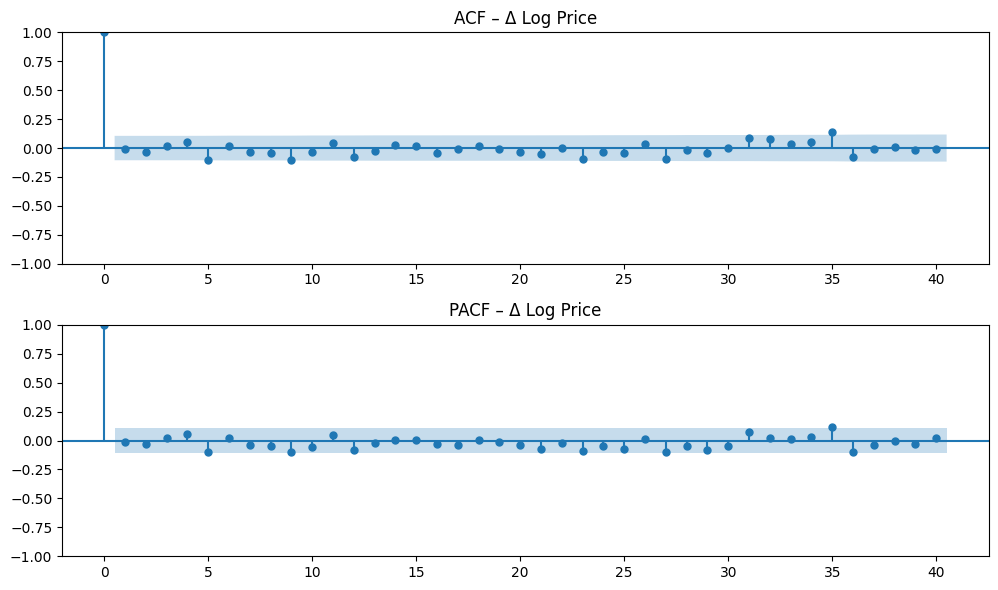

In [11]:
gas['dlog'] = gas['log_price'].diff()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['dlog'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF – Δ Log Price")
plot_pacf(gas['dlog'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Δ Log Price")
plt.tight_layout()
plt.show()

### Check stationarity with DF test on log_price and dlog

DF (Dickey–Fuller) test: H₀ = unit root (non-stationary). Low p-value → reject non-stationary → stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = gas['log_price']
dlog_x = gas['dlog']

print("Log/Diff series:")
print("  ADF :", run_adf(log_x))
print("  ADF :", run_adf(dlog_x))

Log/Diff series:
  ADF : {'stat': np.float64(-3.094343749296179), 'pvalue': np.float64(0.02697461797215903)}
  ADF : {'stat': np.float64(-18.922696691951774), 'pvalue': 0.0}


## 3. Methods and models

### Model selection and justification

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader import data as pdr

### Benchmark models

Train/test split with last 20% as holdout

In [14]:
# Ensure y is your monthly series (MS) with float dtype, as in your code
n = len(gas['log_price'].dropna())
h_test = max(1, int(np.floor(0.20 * n)))  # 20% holdout
y_train = gas['log_price'].iloc[:-h_test]
y_test  = gas['log_price'].iloc[-h_test:]

print(f"Train: {y_train.index[0].date()} → {y_train.index[-1].date()}  (n={len(y_train)})")
print(f"Test : {y_test.index[0].date()} → {y_test.index[-1].date()}    (n={len(y_test)})")

Train: 1997-01-01 → 2020-01-01  (n=277)
Test : 2020-02-01 → 2025-10-01    (n=69)


### AIC/BIC model selection for univariate ARIMA on log_price

In [15]:
y_train_series = y_train  # just to have a clear name

candidate_orders = [
    (1, 0, 0),
    (2, 0, 0),
    (1, 0, 1),
    (0, 0, 1)
]

results_uni = []

for order in candidate_orders:
    model = ARIMA(y_train_series, order=order)
    fit   = model.fit()
    results_uni.append({
        "order": order,
        "aic": fit.aic,
        "bic": fit.bic
    })

aic_uni_df = pd.DataFrame(results_uni).sort_values("aic")
print(aic_uni_df)

best_order_uni = aic_uni_df.iloc[0]["order"]
print("Chosen univariate ARIMA order (p,d,q):", best_order_uni)


       order         aic         bic
0  (1, 0, 0) -328.446992 -317.574940
1  (2, 0, 0) -326.754998 -312.258928
2  (1, 0, 1) -326.735584 -312.239514
3  (0, 0, 1)   84.216137   95.088190
Chosen univariate ARIMA order (p,d,q): (1, 0, 0)


Helper: expanding-window ARIMA forecaster
- We'll use this for the benchmark and AR(1)

In [16]:
def rolling_arima_forecast(y, order, train_size, trend='n'):
    """
    y: Series (e.g. log_price)
    order: (p,d,q)
    train_size: initial length of training sample
    trend: 'n' (no trend), 't' (linear trend), 'ct' (const + trend for d=0)
    """
    y = y.dropna()
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]

    for i in range(train_size, T):
        y_train = y.iloc[:i]
        model = ARIMA(y_train, order=order, trend=trend)
        fit = model.fit()
        f = fit.forecast(steps=1)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals = y.iloc[train_size:]
    return forecasts, actuals


In [17]:
def forecast_metrics(actual, forecast):
    """
    Compute RMSFE and MAFE for 1-step-ahead forecasts.

    actual: pd.Series or np.array with realized values
    forecast: pd.Series or np.array with forecast values
    """
    # make sure they align
    actual = np.asarray(actual)
    forecast = np.asarray(forecast)

    error = forecast - actual   # or actual - forecast, just be consistent
    rmsfe = np.sqrt(np.mean(error**2))
    mafe  = np.mean(np.abs(error))
    return rmsfe, mafe

1.1 Random walk without drift ARIMA(0,1,0)

In [18]:
y_full = gas['log_price']
train_size = len(y_train)

f_rw_nodrift, a_rw_nodrift = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size,
    trend='n'   # NO drift
)
rmsfe_rw_nodrift, mafe_rw_nodrift = forecast_metrics(a_rw_nodrift, f_rw_nodrift)
print("RW NO drift – RMSFE:", rmsfe_rw_nodrift, "MAFE:", mafe_rw_nodrift)


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

RW NO drift – RMSFE: 0.21008899757576888 MAFE: 0.14314705994892313


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

1.2 Benchmark model - Random walk with drift ARIMA(0,1,0)

In [19]:
f_rw_drift, a_rw_drift = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size,
    trend='t'   # linear trend in levels → constant drift in differences
)
rmsfe_rw_drift, mafe_rw_drift = forecast_metrics(a_rw_drift, f_rw_drift)
print("RW WITH drift – RMSFE:", rmsfe_rw_drift, "MAFE:", mafe_rw_drift)



/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

RW WITH drift – RMSFE: 0.21046870419728253 MAFE: 0.14338279026708126


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

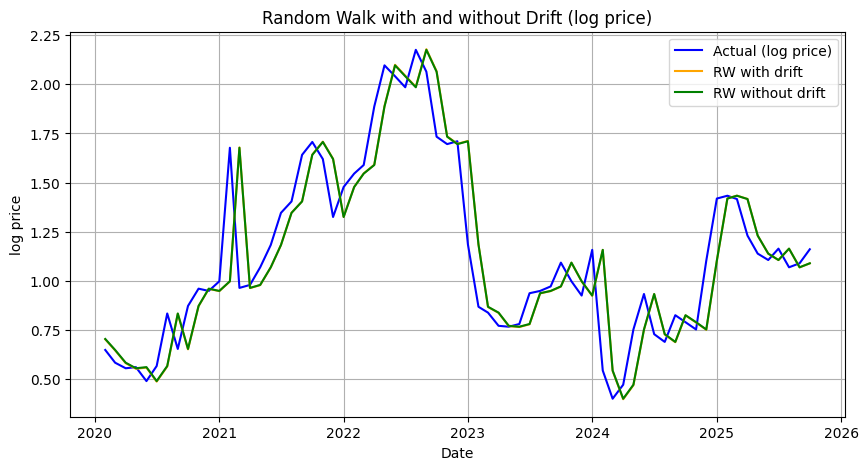

In [20]:
plt.figure(figsize=(10,5))

# Plot actual log price
plt.plot(a_rw_drift.index, a_rw_drift.values, label="Actual (log price)", color="blue")

# Plot RW with drift
plt.plot(f_rw_drift.index, f_rw_drift.values, label="RW with drift", color="orange")

# Plot RW no drift
plt.plot(f_rw_nodrift.index, f_rw_nodrift.values, label="RW without drift", color="green")

plt.title("Random Walk with and without Drift (log price)")
plt.xlabel("Date")
plt.ylabel("log price")
plt.legend()
plt.grid(True)
plt.show()

2. AR(1) on log price: ARIMA(1,0,0) 

In [21]:
f_ar1, a_ar1 = rolling_arima_forecast(
    y_full,
    order=tuple(best_order_uni),
    train_size=train_size
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [22]:
# Compute error and RMSFE
rmsfe_ar1, mafe_ar1 = forecast_metrics(a_ar1, f_ar1)
print("AR(1) – RMSFE:", rmsfe_ar1, "MAFE:", mafe_ar1)

AR(1) – RMSFE: 0.21008266931807196 MAFE: 0.1434842362769176


### Alternative models

Data prep for alternative models 

In [23]:
# Load your dataset
oil = pd.read_csv("data/DCOILWTICO.csv")
oil['observation_date'] = pd.to_datetime(oil['observation_date'])
oil.set_index('observation_date', inplace=True)
oil.rename(columns={'DCOILWTICO': 'oil_price'}, inplace=True)

In [24]:
oil = oil.resample('MS').mean()

In [25]:
expected = pd.date_range(oil.index.min(), oil.index.max(), freq="MS")
missing = expected.difference(oil.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


In [26]:
print(oil.head())
print(oil.tail())
print(f"Observations: {oil.notna().sum()}")

                  oil_price
observation_date           
1997-01-01        25.131818
1997-02-01        22.176316
1997-03-01        20.965000
1997-04-01        19.695455
1997-05-01        20.819048
                  oil_price
observation_date           
2025-06-01        68.169000
2025-07-01        68.390909
2025-08-01        64.864286
2025-09-01        63.959048
2025-10-01        62.590000
Observations: oil_price    346
dtype: int64


### Plot oil

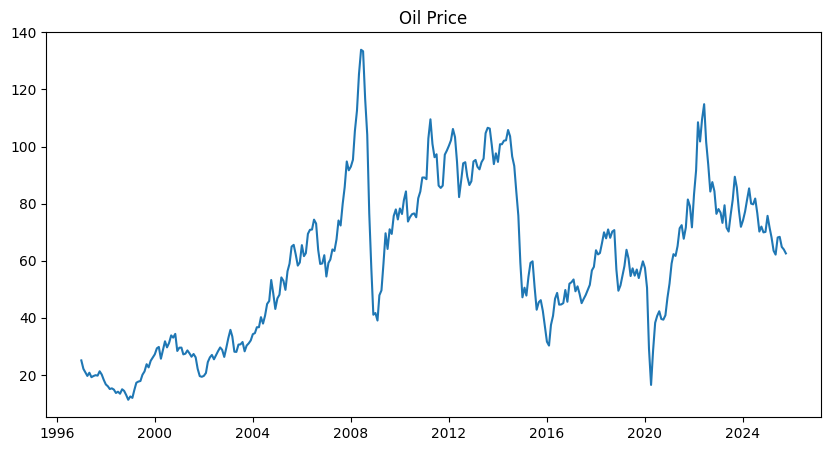

In [27]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['oil_price'], label='Price')
plt.title("Oil Price")
plt.show()

### Logarithmic transformation of oil price

In [28]:
oil['log_oil_price'] = np.log(oil['oil_price'])

In [29]:
print(oil.head())

                  oil_price  log_oil_price
observation_date                          
1997-01-01        25.131818       3.224135
1997-02-01        22.176316       3.099025
1997-03-01        20.965000       3.042854
1997-04-01        19.695455       2.980388
1997-05-01        20.819048       3.035868


### Plot log oil

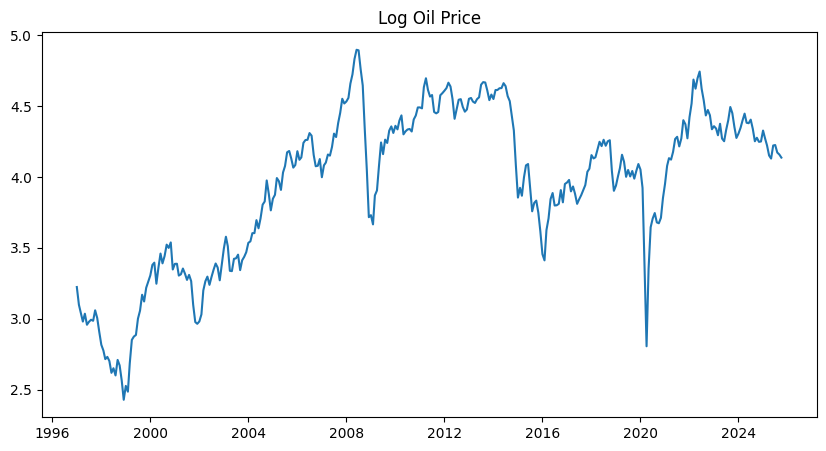

In [30]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['log_oil_price'], label='Price')
plt.title("Log Oil Price")
plt.show()

### Check stationarity with DF test on log_oil_price

In [31]:
def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = oil['log_oil_price']

print("Log series:")
print("  ADF :", run_adf(log_x))

Log series:
  ADF : {'stat': np.float64(-2.283960217429215), 'pvalue': np.float64(0.17719331464393745)}


We fail to reject the null of a unit root so the series is non-stationary

### First difference

In [32]:
oil['dlog_oil'] = oil['log_oil_price'].diff()

### Check stationarity with DF test on dlog_oil

In [33]:
dlog_x = oil['dlog_oil']

print("Diff series:")
print("  ADF :", run_adf(dlog_x))

Diff series:
  ADF : {'stat': np.float64(-12.521038702549626), 'pvalue': np.float64(2.5481331700962578e-23)}


P-value is essentially zero so i strongly reject the unit root null

### Merge log gas and log oil on a new dataframe 

In [34]:

df = gas[['log_price']].join(oil['log_oil_price'], how='inner')

In [35]:
df['dlog'] = df['log_price'].diff()

In [36]:
df['dlog_oil'] = df['log_oil_price'].diff()

In [37]:
df.head()

,log_price,log_oil_price,dlog,dlog_oil
observation_date,,,,
1997-01-01,1.238374,3.224135,NaN,NaN
1997-02-01,0.765468,3.099025,-0.472906,-0.125110
1997-03-01,0.636577,3.042854,-0.128891,-0.056170
1997-04-01,0.708036,2.980388,0.071459,-0.062467
1997-05-01,0.810930,3.035868,0.102894,0.055480


In [38]:
df['dlog_oil_lag1'] = df['dlog_oil'].shift(1)

In [39]:
df = df.dropna()

Split training and test set

In [40]:
N2 = len(df)
test_size2 = int(np.ceil(0.2 * N2))

train2 = df.iloc[:N2 - test_size2]
test2  = df.iloc[N2 - test_size2:]

y2_full = df['dlog']                     # Δlog gas
X2_full = df[['dlog_oil', 'dlog_oil_lag1']]    # Δlog oil, contemporaneous + lag
train_size2 = len(train2)

### AIC/BIC model selection for AR-X on dlog with oil

In [41]:
y_train2 = train2['dlog']
X_train2 = train2[['dlog_oil', 'dlog_oil_lag1']]

candidate_orders_arx = [
    (0, 0, 0),
    (1, 0, 0),
    (2, 0, 0)
]

results_arx = []

for order in candidate_orders_arx:
    model = ARIMA(y_train2, order=order, exog=X_train2)
    fit   = model.fit()
    results_arx.append({
        "order": order,
        "aic": fit.aic,
        "bic": fit.bic
    })

aic_arx_df = pd.DataFrame(results_arx).sort_values("aic")
print(aic_arx_df)

best_order_arx = aic_arx_df.iloc[0]["order"]
print("Chosen AR-X ARIMA order (p,d,q):", best_order_arx)


       order         aic         bic
0  (0, 0, 0) -343.068820 -328.601735
1  (1, 0, 0) -341.099314 -323.015459
2  (2, 0, 0) -339.203465 -317.502838
Chosen AR-X ARIMA order (p,d,q): (0, 0, 0)


Helper: rolling ARIMA with exogenous regressors (AR-X)

In [42]:
def rolling_arima_exog(y, exog, order, train_size):
    """
    y: Series (dependent)
    exog: DataFrame/Series with exogenous regressors (same index as y)
    order: (p,d,q)
    """
    y = y.dropna()
    exog = exog.loc[y.index]  # align
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]

    for i in range(train_size, T):
        y_train   = y.iloc[:i]
        exog_train = exog.iloc[:i]
        exog_fore  = exog.iloc[i:i+1]

        model = ARIMA(y_train, order=order, exog=exog_train)
        fit   = model.fit()
        f     = fit.forecast(steps=1, exog=exog_fore)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals   = y.iloc[train_size:]
    return forecasts, actuals

### 3. Alternative model 1 - AR-X(1,1) on diff log gas with oil 

In [43]:
# Alt 2: AR-X – ARIMA(1,0,0) on dlog_price with exog oil diffs
f_arx, a_arx = rolling_arima_exog(
    y=y2_full,
    exog=X2_full,
    order=tuple(best_order_arx),
    train_size=train_size2
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f     = fit.forecast(steps=1, exog=exog_fore)[0]
/Users/stefanialavarda/Time_Series_Project/ts-gas/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_66227/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f     = fit.forecast(steps=1, exog=exog_fore)[0]
/var/fo

Compute error and RMSFE

In [44]:
rmsfe_arx, mafe_arx = forecast_metrics(a_arx, f_arx)
print("AR-X – RMSFE:", rmsfe_arx, "MAFE:", mafe_arx)

AR-X – RMSFE: 0.21071107509095585 MAFE: 0.14380083534449267


### Alternative model 2 - VAR

Build the VAR dataset & train/test split

In [45]:
from statsmodels.tsa.api import VAR

# Use only the two variables we need for VAR
var_df = df[['dlog', 'dlog_oil']].dropna()

# Train / test split (last 20% as test)
N_var = len(var_df)
test_size_var = int(np.ceil(0.2 * N_var))

train_var = var_df.iloc[:N_var - test_size_var]
test_var  = var_df.iloc[N_var - test_size_var:]

print("Train VAR:", train_var.index[0], "→", train_var.index[-1], f"(n={len(train_var)})")
print("Test VAR :", test_var.index[0],  "→", test_var.index[-1],  f"(n={len(test_var)})")

Train VAR: 1997-03-01 00:00:00 → 2020-01-01 00:00:00 (n=275)
Test VAR : 2020-02-01 00:00:00 → 2025-10-01 00:00:00 (n=69)


Model selection: choose VAR lag p using AIC/BIC

In [46]:
# VAR lag-order selection on training data
model_var = VAR(train_var)
lag_results = model_var.select_order(maxlags=6)  # try lags 1..6
print(lag_results.summary())

# choose p according to AIC (or BIC)
p_aic = lag_results.aic
p_bic = lag_results.bic
print("Lag selected by AIC:", p_aic)
print("Lag selected by BIC:", p_bic)

# pick one (say AIC)
p_var = p_aic

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -8.989     -8.962*   0.0001248      -8.978
1      -9.030      -8.950   0.0001198     -8.998*
2     -9.045*      -8.912  0.0001180*      -8.992
3      -9.029      -8.842   0.0001199      -8.954
4      -9.035      -8.795   0.0001191      -8.939
5      -9.010      -8.716   0.0001223      -8.891
6      -9.012      -8.664   0.0001220      -8.872
-------------------------------------------------
Lag selected by AIC: 2
Lag selected by BIC: 0


Recursive / expanding-window 1-step forecasts from VAR

In [47]:
def rolling_var_forecast(df, p, train_size):
    """
    df: DataFrame with columns ['dlog', 'dlog_oil']
    p: VAR lag order
    train_size: initial number of observations for the first estimation
    Returns: forecasts_df (DataFrame), actuals_df (DataFrame)
    """
    df = df.dropna()
    T = len(df)
    idx_fore = df.index[train_size:]
    forecasts = []

    for i in range(train_size, T):
        train_i = df.iloc[:i]
        model_i = VAR(train_i)
        res_i   = model_i.fit(p)
        # last p observations as initial state
        y_last = train_i.values[-p:]
        f_1 = res_i.forecast(y_last, steps=1)[0]  # 1-step ahead forecast
        forecasts.append(f_1)

    forecasts_df = pd.DataFrame(forecasts, index=idx_fore, columns=df.columns)
    actuals_df   = df.iloc[train_size:]
    return forecasts_df, actuals_df

# Use full var_df and train_size = len(train_var)
train_size_var = len(train_var)

var_forecasts, var_actuals = rolling_var_forecast(
    var_df,
    p=p_var,
    train_size=train_size_var
)


Evaluation: RMSFE & MAFE for gas equation

In [48]:
f_var_gas = var_forecasts['dlog']
a_var_gas = var_actuals['dlog']

rmsfe_var, mafe_var = forecast_metrics(a_var_gas, f_var_gas)
print("VAR – RMSFE:", rmsfe_var, "MAFE:", mafe_var)

VAR – RMSFE: 0.20884963117527816 MAFE: 0.1439890648344518


### Factor model using PCA on FRED-MD series

Load FRED-MD

In [50]:
# Load your chosen vintage (e.g., "2025-10.csv")
fred = pd.read_csv("data/2025-10-MD.csv")

# Identify the date column
date_col = "sasdate" if "sasdate" in fred.columns else "DATE"

# Drop the "Transform:" row BEFORE parsing dates
fred = fred.drop(index=0)   # This removes the tcode row

# Now parse dates safely
fred[date_col] = pd.to_datetime(fred[date_col], format="%m/%d/%Y")

# Set index
fred = fred.set_index(date_col)

# Convert all other columns to floats
fred = fred.astype(float)


In [51]:
print(fred.head())

                 RPI  W875RX1  DPCERA3M086SBEA    CMRMTSPLx      RETAILx  \
sasdate                                                                    
1959-01-01  2583.560   2426.0           15.188  276676.8154  17689.23968   
1959-02-01  2593.596   2434.8           15.346  278713.9773  17819.01912   
1959-03-01  2610.396   2452.7           15.491  277775.2539  17967.91336   
1959-04-01  2627.446   2470.0           15.435  283362.7075  17978.97983   
1959-05-01  2642.720   2486.4           15.622  285307.2201  18119.82573   

             INDPRO  IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  ...  \
sasdate                                                   ...   
1959-01-01  21.9616  23.3868  22.2620  31.6664   18.9498  ...   
1959-02-01  22.3917  23.7024  22.4549  31.8987   19.0492  ...   
1959-03-01  22.7142  23.8459  22.5651  31.8987   19.4223  ...   
1959-04-01  23.1981  24.1903  22.8957  32.4019   19.5466  ...   
1959-05-01  23.5476  24.3911  23.1161  32.5567   19.9445  ...   

           

Restrict to your gas sample & remove missing columns

In [52]:
# Align FRED-MD to your gas price sample window
X_raw = fred.loc[gas.index.min(): gas.index.max()]

# Drop variables with missing values
X_raw = X_raw.dropna(axis=1, how="any")


Standardize and run PCA — extract PC1

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [54]:
# Standardize (important for PCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_raw)

# PCA on standardized data
pca = PCA(n_components=1)
pc1_vals = pca.fit_transform(X_std)

# PC1 series
pc1 = pd.Series(pc1_vals[:, 0], index=X_raw.index, name="PC1")


Build dataset for the factor model (log gas)

In [55]:
df_factor = pd.DataFrame({
    "log_gas": gas['log_price'],
    "log_gas_l1": gas['log_price'].shift(1),
    "F_l1": pc1.shift(1)       # lag the factor
}).dropna()

Rolling (recursive) 1-step-ahead forecasts

In [56]:
import statsmodels.api as sm

In [57]:
def rolling_factor_forecast(df, initial_window):
    y_all = df["log_gas"]
    X_all = sm.add_constant(df[["log_gas_l1", "F_l1"]])

    actual = []
    forecast = []

    for t in range(initial_window, len(df)):
        # training sample up to t-1
        y_train = y_all.iloc[:t]
        X_train = X_all.iloc[:t]

        # 1-step-ahead: predict y_t
        X_t = X_all.iloc[t:t+1]

        model = sm.OLS(y_train, X_train).fit()
        f_hat = model.predict(X_t).iloc[0]

        actual.append(y_all.iloc[t])
        forecast.append(f_hat)

    idx = y_all.index[initial_window:]
    a_factor = pd.Series(actual, index=idx, name="actual_factor")
    f_factor = pd.Series(forecast, index=idx, name="forecast_factor")

    return a_factor, f_factor

# Example: 60-month initial window
a_fac, f_fac = rolling_factor_forecast(df_factor, initial_window=60)

In [58]:
def forecast_metrics(actual, forecast):
    err = forecast - actual
    rmsfe = np.sqrt(np.mean(err**2))
    mafe = np.mean(np.abs(err))
    return rmsfe, mafe

In [59]:
rmsfe_fac, mafe_fac = forecast_metrics(a_fac, f_fac)
print("Factor model RMSFE:", rmsfe_fac)
print("Factor model MAFE:", mafe_fac)

Factor model RMSFE: 0.15382117024736913
Factor model MAFE: 0.11131219798185459


## 4. Evaluation

One helper function to compare any alternative with AR(1)

In [66]:
def evaluate_against_benchmark(a_bench, f_bench, a_alt, f_alt, alt_name="alt"):
    # 1. Put everything into one DataFrame, like before
    pair = pd.concat(
        [
            a_bench.rename("a_bench"),   # AR(1) actuals  (log)
            f_bench.rename("f_bench"),   # AR(1) forecasts (log)
            a_alt.rename("a_alt"),       # AR-X actuals    (dlog)
            f_alt.rename("f_alt"),       # AR-X forecasts  (dlog)
        ],
        axis=1,
        join="inner"
    ).dropna()

    # 2. Benchmark metrics: log vs log forecast
    rmsfe_bench, mafe_bench = forecast_metrics(pair["a_bench"], pair["f_bench"])

    # 3. Alternative metrics: dlog vs dlog forecast
    rmsfe_alt,   mafe_alt   = forecast_metrics(pair["a_alt"],   pair["f_alt"])

    # 4. Ratios
    ratio_rmsfe = rmsfe_alt / rmsfe_bench
    ratio_mafe  = mafe_alt  / mafe_bench

    # 5. Print nicely
    print(f"=== {alt_name} vs AR(1) ===")
    print(f"Benchmark AR(1) - RMSFE: {rmsfe_bench:.6f}, MAFE: {mafe_bench:.6f}")
    print(f"{alt_name}          - RMSFE: {rmsfe_alt:.6f}, MAFE: {mafe_alt:.6f}")
    print(f"RMSFE ratio (alt / AR1): {ratio_rmsfe:.3f}")
    print(f"MAFE  ratio (alt / AR1): {ratio_mafe:.3f}")


Run it for AR-X and the Factor model

In [67]:
results = []

res_arx = evaluate_against_benchmark(a_ar1, f_ar1, a_arx, f_arx, alt_name="AR-X (oil)")
results.append(res_arx)

res_fac = evaluate_against_benchmark(a_ar1, f_ar1, a_fac, f_fac, alt_name="Factor (PC1)")
results.append(res_fac)


=== AR-X (oil) vs AR(1) ===
Benchmark AR(1) - RMSFE: 0.210083, MAFE: 0.143484
AR-X (oil)          - RMSFE: 0.210711, MAFE: 0.143801
RMSFE ratio (alt / AR1): 1.003
MAFE  ratio (alt / AR1): 1.002
=== Factor (PC1) vs AR(1) ===
Benchmark AR(1) - RMSFE: 0.211408, MAFE: 0.144442
Factor (PC1)          - RMSFE: 0.209027, MAFE: 0.143359
RMSFE ratio (alt / AR1): 0.989
MAFE  ratio (alt / AR1): 0.993


Cumulative RMSFE ratio

In [62]:
# AR(1) errors
errors_ar1 = a_ar1 - f_ar1

# AR-X errors
errors_arx = a_arx - f_arx

In [68]:
import numpy as np
import pandas as pd

# errors
errors_ar1 = a_ar1 - f_ar1
errors_arx = a_arx - f_arx

# cumulative MSE
cum_mse_ar1 = np.cumsum(errors_ar1**2) / np.arange(1, len(errors_ar1)+1)
cum_mse_arx = np.cumsum(errors_arx**2) / np.arange(1, len(errors_arx)+1)

# cumulative RMSFE
cum_rmsfe_ar1 = np.sqrt(cum_mse_ar1)
cum_rmsfe_arx = np.sqrt(cum_mse_arx)

# ratio
cum_ratio = cum_rmsfe_arx / cum_rmsfe_ar1

cum_df = pd.DataFrame({
    "cum_rmsfe_ar1": cum_rmsfe_ar1,
    "cum_rmsfe_arx": cum_rmsfe_arx,
    "cum_ratio": cum_ratio
})

cum_df.head(15)


,cum_rmsfe_ar1,cum_rmsfe_arx,cum_ratio
observation_date,,,
2020-02-01,0.052238,0.016118,0.308550
2020-03-01,0.056997,0.072139,1.265668
2020-04-01,0.048749,0.095357,1.956095
2020-05-01,0.042445,0.110051,2.592765
2020-06-01,0.048631,0.117737,2.421029
2020-07-01,0.054981,0.110932,2.017631
2020-08-01,0.114279,0.142265,1.244893
2020-09-01,0.123732,0.145484,1.175800
2020-10-01,0.138244,0.155724,1.126443


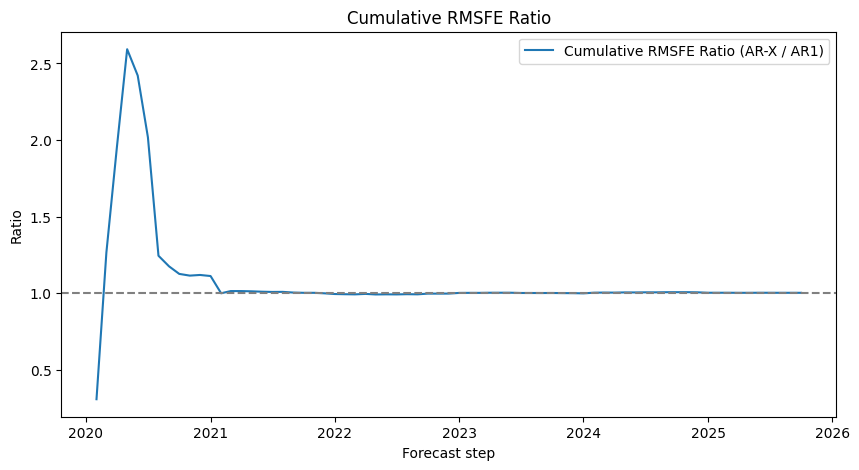

In [69]:
plt.figure(figsize=(10,5))
plt.plot(cum_ratio, label="Cumulative RMSFE Ratio (AR-X / AR1)")
plt.axhline(1, color="grey", linestyle="--")
plt.title("Cumulative RMSFE Ratio")
plt.ylabel("Ratio")
plt.xlabel("Forecast step")
plt.legend()
plt.show()


## Comparison plot

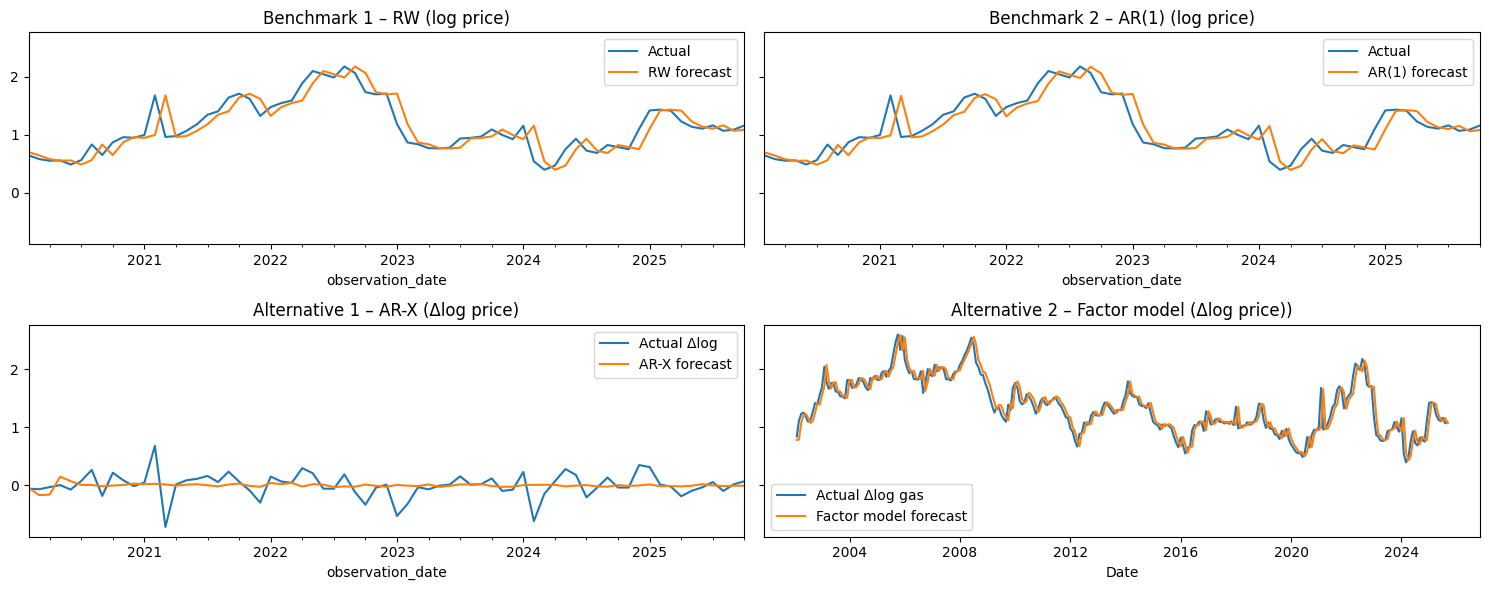

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(15, 6), sharey=True)

# Top-left: RW benchmark 
a_rw_nodrift.plot(ax=ax[0, 0], label="Actual")
f_rw_nodrift.plot(ax=ax[0, 0], label="RW forecast")
ax[0, 0].set_title("Benchmark 1 – RW (log price)")
ax[0, 0].legend()

# Top-right: AR(1) benchmark 
a_ar1.plot(ax=ax[0, 1], label="Actual")
f_ar1.plot(ax=ax[0, 1], label="AR(1) forecast")
ax[0, 1].set_title("Benchmark 2 – AR(1) (log price)")
ax[0, 1].legend()

# Bottom-left: AR-X
a_arx.plot(ax=ax[1, 0], label="Actual Δlog")
f_arx.plot(ax=ax[1, 0], label="AR-X forecast")
ax[1, 0].set_title("Alternative 1 – AR-X (Δlog price)")
ax[1, 0].legend()

# Bottom-right: Factor Model 
ax[1, 1].plot(a_fac.index, a_fac.values, label="Actual Δlog gas")
ax[1, 1].plot(f_fac.index, f_fac.values, label="Factor model forecast")
ax[1, 1].set_title("Alternative 2 – Factor model (Δlog price))")
ax[1, 1].set_xlabel("Date")
ax[1, 1].set_ylabel("Δlog gas")
ax[1, 1].legend()

# Add more vertical spacing 
plt.subplots_adjust(hspace=1)  # increase space between rows

plt.tight_layout()
plt.show()


## 5. Diagnostics

### AR(1) benchmark – diagnostics

a) Residuals

AR(1) residuals – summary:
count    69.000000
mean      0.012376
std       0.211254
min      -0.707572
25%      -0.061932
50%       0.018681
75%       0.119647
max       0.685134
Name: res_ar1, dtype: float64

Mean of residuals (should be close to 0): 0.012376386973305021


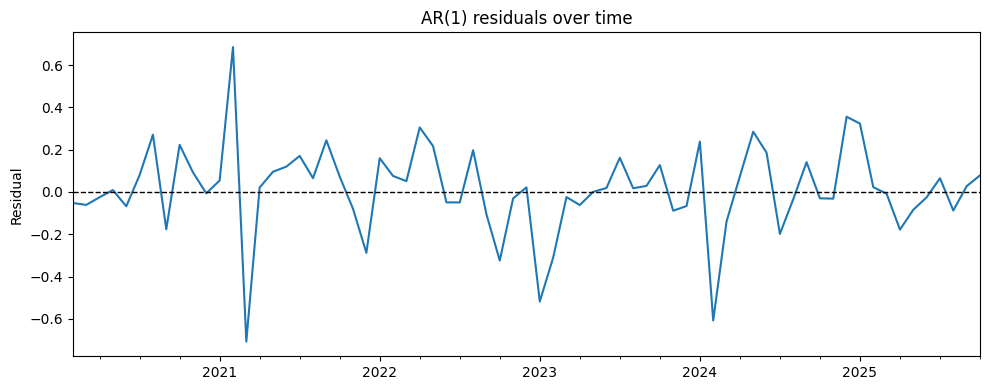

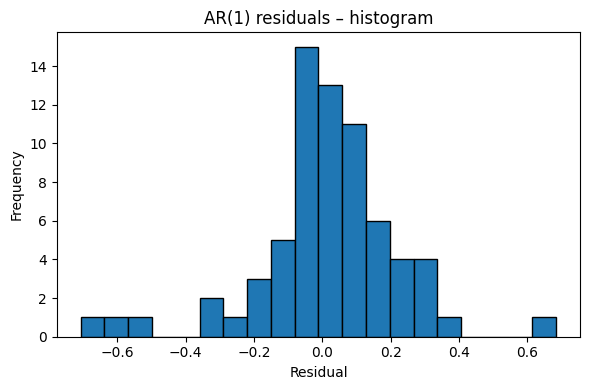

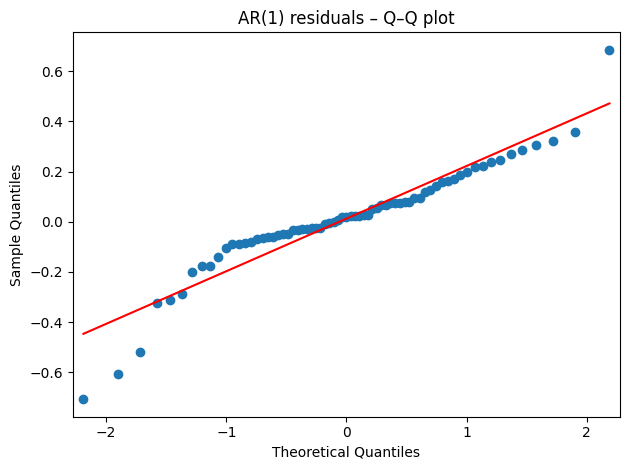

In [72]:
# AR(1) residuals
res_ar1 = a_ar1 - f_ar1
res_ar1.name = "res_ar1"

# Summary stats
print("AR(1) residuals – summary:")
print(res_ar1.describe())
print("\nMean of residuals (should be close to 0):", res_ar1.mean())

# Time series plot of residuals
fig, ax = plt.subplots(figsize=(10, 4))
res_ar1.plot(ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1)
ax.set_title("AR(1) residuals over time")
ax.set_ylabel("Residual")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(res_ar1.dropna(), bins=20, edgecolor="k")
ax.set_title("AR(1) residuals – histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Q–Q plot for normality
import statsmodels.api as sm
sm.qqplot(res_ar1.dropna(), line="s")
plt.title("AR(1) residuals – Q–Q plot")
plt.tight_layout()
plt.show()


b) ACF / PACF of residuals

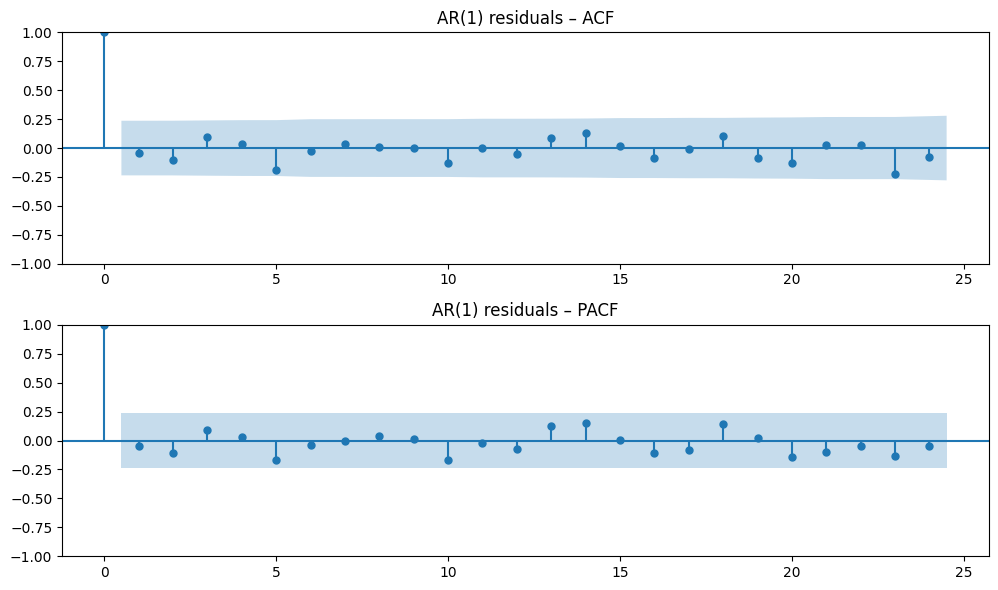

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(res_ar1.dropna(), lags=24, ax=ax[0])
ax[0].set_title("AR(1) residuals – ACF")
plot_pacf(res_ar1.dropna(), lags=24, ax=ax[1])
ax[1].set_title("AR(1) residuals – PACF")
plt.tight_layout()
plt.show()


c) Stability check for AR(1)

In [74]:
# One-shot AR(1) on full log series
model_ar1_full = ARIMA(y_full.dropna(), order=tuple(best_order_uni), trend='n')
fit_ar1_full = model_ar1_full.fit()

print(fit_ar1_full.summary())

# AR(1) coefficient (phi_1)
phi1 = fit_ar1_full.arparams[0]
print("\nEstimated AR(1) coefficient phi1:", phi1)
print("Is |phi1| < 1 (stationary / stable)? ->", abs(phi1) < 1)

# For AR(1) the root of the characteristic polynomial is 1/phi1
if phi1 != 0:
    root = 1 / phi1
    print("Root of AR(1) polynomial:", root, "|root| >", 1, "->", abs(root) > 1)


                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  346
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 159.959
Date:                Tue, 25 Nov 2025   AIC                           -315.918
Time:                        16:28:16   BIC                           -308.225
Sample:                    01-01-1997   HQIC                          -312.855
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9938      0.006    177.695      0.000       0.983       1.005
sigma2         0.0229      0.001     21.108      0.000       0.021       0.025
Ljung-Box (L1) (Q):                   0.09   Jarque-

### Factor (PC1) model – diagnostics

a) Residuals

Factor model residuals – summary:
count    284.000000
mean      -0.007588
std        0.153905
min       -0.695700
25%       -0.093140
50%       -0.012631
75%        0.076980
max        0.679338
Name: res_fac, dtype: float64

Mean of residuals (should be close to 0): -0.007588059878670073


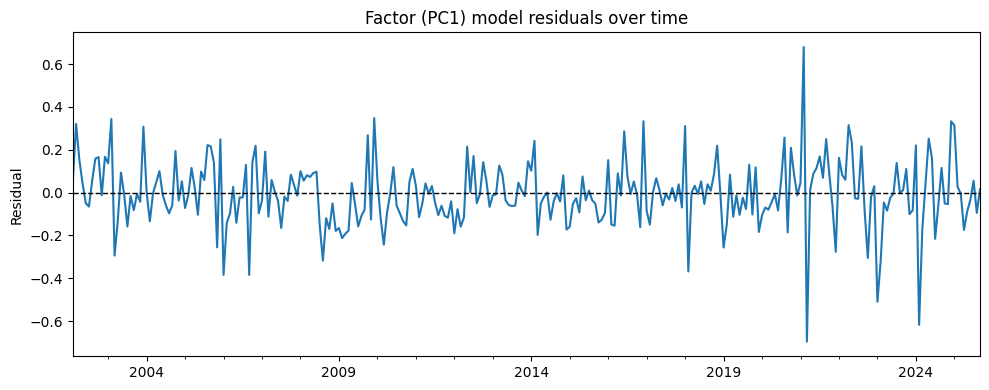

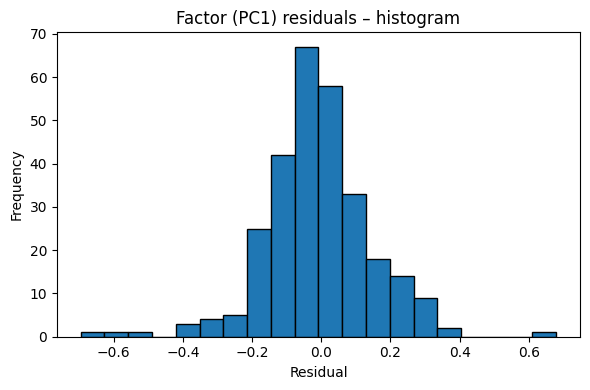

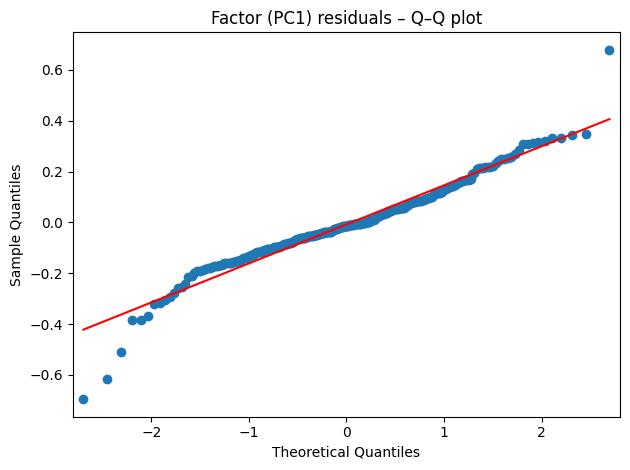

In [75]:
# Factor model residuals
res_fac = a_fac - f_fac
res_fac.name = "res_fac"

# Summary stats
print("Factor model residuals – summary:")
print(res_fac.describe())
print("\nMean of residuals (should be close to 0):", res_fac.mean())

# Time series plot of residuals
fig, ax = plt.subplots(figsize=(10, 4))
res_fac.plot(ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1)
ax.set_title("Factor (PC1) model residuals over time")
ax.set_ylabel("Residual")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(res_fac.dropna(), bins=20, edgecolor="k")
ax.set_title("Factor (PC1) residuals – histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Q–Q plot
sm.qqplot(res_fac.dropna(), line="s")
plt.title("Factor (PC1) residuals – Q–Q plot")
plt.tight_layout()
plt.show()

b) ACF / PACF of residuals

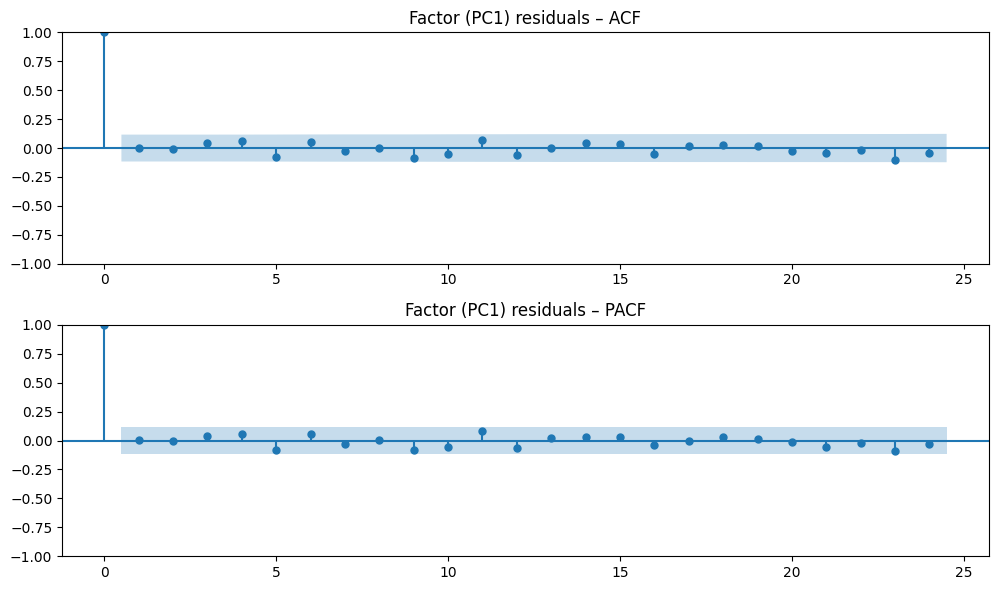

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(res_fac.dropna(), lags=24, ax=ax[0])
ax[0].set_title("Factor (PC1) residuals – ACF")
plot_pacf(res_fac.dropna(), lags=24, ax=ax[1])
ax[1].set_title("Factor (PC1) residuals – PACF")
plt.tight_layout()
plt.show()

c) Stability check for AR(1)

In [77]:
# Full-sample factor model (no rolling) to check stability
y_fac_full = df_factor["log_gas"]
X_fac_full = sm.add_constant(df_factor[["log_gas_l1", "F_l1"]])

ols_fac_full = sm.OLS(y_fac_full, X_fac_full).fit()
print(ols_fac_full.summary())

phi1_fac = ols_fac_full.params["log_gas_l1"]
print("\nCoefficient on log_gas_l1 (phi1 in factor model):", phi1_fac)
print("Is |phi1_fac| < 1 (stable AR part)? ->", abs(phi1_fac) < 1)

                            OLS Regression Results                            
Dep. Variable:                log_gas   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1439.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          5.81e-167
Time:                        16:30:50   Log-Likelihood:                 165.11
No. Observations:                 344   AIC:                            -324.2
Df Residuals:                     341   BIC:                            -312.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0727      0.025      2.949      0.0